In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import os
#PROJECT_ROOT = '/content/drive/My Drive/tfm/codigo' #@param {type:"string"}
#os.chdir(PROJECT_ROOT)
#print("Current working directory:", os.getcwd())


Current working directory: /content/drive/My Drive/tfm/codigo


In [ ]:
#!pip install python-dotenv
import os
from dotenv import load_dotenv

# Librerías

In [71]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Base de Datos y Variables de Entorno
from conexion import connect_to_postgresql, plot_predictions, evaluate_model, get_model_results, evaluate_feature_importance

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

# Machine Learning y estadística
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

# importación de Modelo
import joblib


In [5]:
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.2f}'.format

In [6]:
engine = connect_to_postgresql()
conn = engine.raw_connection()
cur = conn.cursor()
try:
    query = """
    SELECT * FROM public.ft_indicadores;
    """
    cur.execute(query)

    df_ml = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

    conn.commit()
    print("La consulta se ha ejecutado con éxito")
except Exception as e:
    print(f"Ha ocurrido un error: {str(e)}")
finally:
    cur.close()
    conn.close()

df_ml.head()

Conexión establecida
La consulta se ha ejecutado con éxito


,Fecha,Habitaciones,Aseos,Precio,Metros,CUDIS,Provincia,Población,Renta bruta media por persona,Comodidades,Capital,Municipio_Tipo,Precio_medio_mun_tipo
0,2021-12-31,2.00,1.00,"56,000.00",66.00,"2,408,909.00",León,"120,082.00","35,956.00",0,True,León_Apartment,"131,994.02"
1,2021-12-31,3.00,2.00,"89,000.00",105.00,"2,408,907.00",León,"120,082.00","35,956.00",1,True,León_Apartment,"131,994.02"
2,2021-12-31,1.00,1.00,"55,000.00",45.00,"2,408,903.00",León,"120,082.00","35,956.00",0,True,León_Apartment,"131,994.02"
3,2021-12-31,3.00,1.00,"80,000.00",87.00,"2,408,906.00",León,"120,082.00","35,956.00",2,True,León_Apartment,"131,994.02"
4,2021-12-31,2.00,1.00,"56,000.00",66.00,"2,408,909.00",León,"120,082.00","35,956.00",1,True,León_Apartment,"131,994.02"


In [7]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16769 entries, 0 to 16768
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Fecha                          16769 non-null  datetime64[ns]
 1   Habitaciones                   16769 non-null  float64       
 2   Aseos                          16769 non-null  float64       
 3   Precio                         16769 non-null  float64       
 4   Metros                         16769 non-null  float64       
 5   CUDIS                          16769 non-null  float64       
 6   Provincia                      16769 non-null  object        
 7   Población                      16769 non-null  float64       
 8   Renta bruta media por persona  16769 non-null  float64       
 9   Comodidades                    16769 non-null  int64         
 10  Capital                        16769 non-null  bool          
 11  Municipio_Tipo 

In [8]:
#df_ml['Anno'] = df_ml['Fecha'].dt.year

In [9]:
#df_provincias = df_ml.drop(columns=["Municipio"])
#
#print("DataFrame solo con las provincias:")
#df_provincias.head()

In [10]:
#dataframes_por_provincia = {provincia: data.reset_index(drop=True) for provincia, data in df_ml.groupby("Provincia")}
#
#for provincia, data in df_ml.groupby("Provincia"):
#    exec(f"df_{provincia} = data.reset_index(drop=True)")
#    print(f"Variable creada: df_{provincia}")


In [11]:
df = df_ml.drop(['Fecha', 'Municipio_Tipo', 'Provincia', 'Capital'], axis = 1).copy() #
df.head()

,Habitaciones,Aseos,Precio,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Precio_medio_mun_tipo
0,2.00,1.00,"56,000.00",66.00,"2,408,909.00","120,082.00","35,956.00",0,"131,994.02"
1,3.00,2.00,"89,000.00",105.00,"2,408,907.00","120,082.00","35,956.00",1,"131,994.02"
2,1.00,1.00,"55,000.00",45.00,"2,408,903.00","120,082.00","35,956.00",0,"131,994.02"
3,3.00,1.00,"80,000.00",87.00,"2,408,906.00","120,082.00","35,956.00",2,"131,994.02"
4,2.00,1.00,"56,000.00",66.00,"2,408,909.00","120,082.00","35,956.00",1,"131,994.02"


# Métodos Supervisados

Vamos a empezar estudiando el conjunto de datos total para ver como se desarrolla el proceso de ML y si vemos que es demasiado, reduciremos solo a provincias.

In [12]:
obs_X = df.drop(columns=['Precio'])
obs_X['Precio_medio_mun_tipo'] = np.log(obs_X['Precio_medio_mun_tipo'])
obj_Y = np.log(df[['Precio']])

In [13]:
# One-hot encoding de las variables categóricas
categorical_columns = list(obs_X.select_dtypes(['object']).columns)
obs_X_encoded  = pd.get_dummies(
    obs_X,
    columns=categorical_columns,
    drop_first=True
)
obs_X_encoded.head()

,Habitaciones,Aseos,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Precio_medio_mun_tipo
0,2.00,1.00,66.00,"2,408,909.00","120,082.00","35,956.00",0,11.79
1,3.00,2.00,105.00,"2,408,907.00","120,082.00","35,956.00",1,11.79
2,1.00,1.00,45.00,"2,408,903.00","120,082.00","35,956.00",0,11.79
3,3.00,1.00,87.00,"2,408,906.00","120,082.00","35,956.00",2,11.79
4,2.00,1.00,66.00,"2,408,909.00","120,082.00","35,956.00",1,11.79


In [14]:
# Normalizar las columnas numéricas
numeric_columns = list(obs_X.select_dtypes(['number']).columns)
numeric_vars = obs_X_encoded[numeric_columns]

scaler_X = StandardScaler()
numeric_vars_scaled = scaler_X.fit_transform(numeric_vars)
obs_X_encoded[numeric_columns] = numeric_vars_scaled

In [15]:
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(obj_Y)
obj_Y_scaled = pd.DataFrame(y_scaled, columns=['Precio'])

In [16]:
# Convertir solo las columnas categóricas (True/False) a 0/1
categorical_columns_encoded = list(set(obs_X_encoded.columns) - set(numeric_columns))
obs_X_encoded[categorical_columns_encoded] = obs_X_encoded[categorical_columns_encoded].astype(int)

obs_X_encoded.head()

,Habitaciones,Aseos,Metros,CUDIS,Población,Renta bruta media por persona,Comodidades,Precio_medio_mun_tipo
0,-0.92,-0.89,-0.91,-0.45,0.51,1.04,-0.77,0.55
1,0.24,0.88,0.36,-0.45,0.51,1.04,0.90,0.55
2,-2.09,-0.89,-1.60,-0.45,0.51,1.04,-0.77,0.55
3,0.24,-0.89,-0.22,-0.45,0.51,1.04,2.58,0.55
4,-0.92,-0.89,-0.91,-0.45,0.51,1.04,0.90,0.55


## Colinealidad

In [17]:
data_encoded = obs_X_encoded.copy()

In [18]:
# Eliminar columnas con baja varianza
selector = VarianceThreshold(threshold=0.01)  # Eliminar casi constantes
reduced_data = selector.fit_transform(data_encoded)
selected_columns = data_encoded.columns[selector.get_support()]
data_encoded = pd.DataFrame(reduced_data, columns=selected_columns)


In [19]:
vif_data = pd.DataFrame()
vif_data['Variable'] = data_encoded.columns
vif_data['VIF'] = [
    sm.OLS(data_encoded[col], sm.add_constant(data_encoded.drop(columns=[col]))).fit().rsquared
    if np.linalg.matrix_rank(data_encoded.drop(columns=[col])) == data_encoded.drop(columns=[col]).shape[1]
    else float('inf')  # Asignar infinito si la matriz es singular
    for col in data_encoded.columns
]

# Filtrar variables con VIF infinito
vif_data = vif_data[vif_data['VIF'] < float('inf')]
print("VIF calculado:")
print(vif_data)


VIF calculado:
                        Variable  VIF
0                   Habitaciones 0.42
1                          Aseos 0.34
2                         Metros 0.53
3                          CUDIS 0.08
4                      Población 0.47
5  Renta bruta media por persona 0.55
6                    Comodidades 0.05
7          Precio_medio_mun_tipo 0.55


In [20]:
# Filtrar columnas con VIF mayor a 5
high_vif_columns = vif_data[vif_data['VIF'] > 5]['Variable']
print("Columnas con VIF mayor a 5:")
print(high_vif_columns)

Columnas con VIF mayor a 5:
Series([], Name: Variable, dtype: object)


Hemos llevado a cabo un análisis de multicolinealidad utilizando el **Variance Inflation Factor (VIF)** para identificar posibles relaciones lineales fuertes entre las variables predictoras de nuestro modelo. Este procedimiento es crucial para garantizar la estabilidad y precisión del modelo de machine learning que estamos construyendo. Primero, preparamos los datos aplicando normalización a las variables numéricas y codificación tipo one-hot a las categóricas. Posteriormente, eliminamos columnas constantes y aseguramos que los datos estuvieran correctamente estructurados.

El resultado del análisis muestra valores de VIF para cada variable, donde un valor bajo (<1) indica que no hay problemas de multicolinealidad significativos. Esto confirma que las variables incluidas en el modelo son independientes entre sí, asegurando un modelo más robusto. Por lo tanto, no es necesario eliminar ninguna variable en este caso, ya que todas las características están adecuadamente preparadas y son aptas para la siguiente etapa del proceso de modelado. ¡Estamos listos para avanzar! 😊


Ahora bien ¿qué métodos se pueden aplicar?

- Regresión lineal: Ideal para empezar, especialmente si tus variables tienen relaciones lineales con el precio. Es simple y fácil de interpretar.

- Árboles de decisión: Capturan relaciones no lineales entre las características y la variable objetivo. Además, son interpretables y útiles para problemas con datos heterogéneos.

- Random Forest: Una técnica basada en múltiples árboles de decisión. Es más robusta, reduce el riesgo de overfitting y puede manejar colinealidad.

- Gradient Boosting Machines (GBM): Modelos como XGBoost o LightGBM son extremadamente potentes, especialmente para problemas complejos. Su rendimiento suele ser alto, aunque requieren más ajuste de hiperparámetros.

- Redes Neuronales Artificiales (ANN): Muy útiles si tu dataset es grande y presenta patrones complejos. Las redes neuronales son capaces de modelar relaciones no lineales, pero necesitan más potencia computacional y pueden ser menos interpretables.

- Support Vector Machines (SVM): Puede ser útil para regresión, especialmente si tus datos no son linealmente separables. Funciona bien con datasets pequeños y complejos.

- k-Nearest Neighbors (k-NN): Una opción simple para predecir el precio basándose en las observaciones más cercanas. Aunque puede ser sensible a la escala y a los valores atípicos.

- Regresión Ridge y Lasso: Variaciones de la regresión lineal que son útiles para reducir el impacto de la multicolinealidad y realizar selección de características.

- Modelos ensamble: Combina varias técnicas como Random Forest y Gradient Boosting para mejorar el rendimiento general.

## Datos de entrenamiento y test

In [21]:
y = obj_Y_scaled['Precio'].copy()
X = data_encoded.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)


Dimensiones de X_train: (11738, 8)
Dimensiones de X_test: (5031, 8)
Dimensiones de y_train: (11738,)
Dimensiones de y_test: (5031,)


In [22]:
model_results = []

## Regresión lineal

Respecto a los métodos supervisados, se va a aplicar en primera instancia una Regresión Lineal, por tantear el comportamiento de los datos para, después aplicar uno de los otros métodos.

### Entrenamiento

In [23]:
linear_model = LinearRegression()
Modelo = "Regresión lineal"
predictions, model_results = evaluate_model(Modelo, linear_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Regresión lineal',
 'RMSE': 37401.24157704523,
 'MAE': 28104.688994411084,
 'R²': 0.5366949480727105,
 'Desviación promedio (%)': 28.690069377212385,
 'Tiempo entrenamiento (s)': 0.04461359977722168,
 'RMSE CV': 11.84485780252237,
 'RMSE CV std': 0.0069545769501641866,
 'R² CV': 0.601196318983337,
 'R² CV std': 0.015560823023688296}

### Gráficas

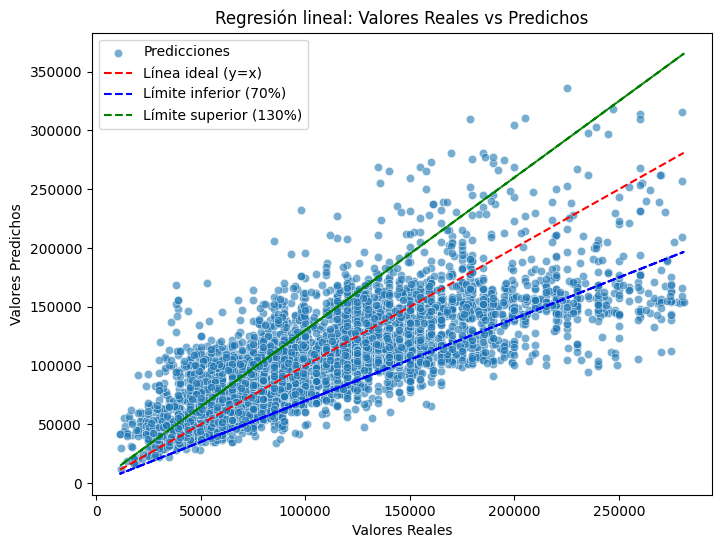

In [24]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Árbol de decisión

### Modelo sin hiperparámetros

In [25]:
tree_model = DecisionTreeRegressor()
Modelo = 'Árbol de decisión sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, tree_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Árbol de decisión sin hiperparámetros',
 'RMSE': 39251.69337565478,
 'MAE': 27206.26132667221,
 'R²': 0.4897161866952012,
 'Desviación promedio (%)': 28.120553905331736,
 'Tiempo entrenamiento (s)': 0.19477438926696777,
 'RMSE CV': 11.895313643311137,
 'RMSE CV std': 0.006213010249071984,
 'R² CV': 0.4731322967452978,
 'R² CV std': 0.0215906111668842}

### Hiperparámetros

- **max_depth**: Limita la profundidad del árbol. Controlar este hiperparámetro ayuda a evitar el sobreajuste (cuando el árbol es demasiado profundo) o el subajuste (cuando el árbol es muy superficial).
- **min_samples_split**: Define el número mínimo de muestras necesarias para dividir un nodo. Un valor más alto puede hacer que el árbol sea menos complejo.
- **min_samples_leaf**: Determina el número mínimo de muestras que debe haber en una hoja. Incrementar este valor puede reducir el ruido del modelo.
- **max_features**: Especifica el número máximo de características que el árbol puede considerar para dividir en cada nodo. Esto puede ser un porcentaje, un número entero o "sqrt", "log2".
- **max_leaf_nodes**: Establece un límite en el número total de nodos terminales (hojas) que puede tener el árbol.
- **criterion**: Define la función que mide la calidad de una división, como "mse" (error cuadrático medio) para problemas de regresión o "gini"/"entropy" para clasificación.
- **splitter**: Determina la estrategia de división en cada nodo, como "best" (mejor partición) o "random" (divisiones aleatorias).

- Estrategia para analizar los hiperparámetros:
    - Para hacer un estudio de estos hiperparámetros:
        - Grid Search: Realiza una búsqueda exhaustiva probando diferentes combinaciones de hiperparámetros usando GridSearchCV.
        - Randomized Search: Para explorar los hiperparámetros más eficientemente, especialmente si el espacio de búsqueda es grande.
        - Validación cruzada: Combínalo con la búsqueda de hiperparámetros para evaluar el rendimiento del modelo en diferentes particiones del dataset.

In [26]:
tree = DecisionTreeRegressor()

#  hiperparámetros
param_grid = {
    'max_depth': [5, 15, 30, None],
    'min_samples_split': [10, 50, 100],
    'min_samples_leaf': [2, 10, 25],
    'max_leaf_nodes': [None, 10, 20]
}

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error',  verbose=3) #n_jobs=-1,
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10;, score=-0.620 total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10;, score=-0.643 total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10;, score=-0.607 total time=   0.0s
[CV 4/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10;, score=-0.658 total time=   0.0s
[CV 5/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=10;, score=-0.633 total time=   0.0s
[CV 1/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=50;, score=-0.619 total time=   0.0s
[CV 2/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=50;, score=-0.645 total time=   0.0s
[CV 3/5] END max_depth=5, max_leaf_nodes=None, min_samples_leaf=2, min_samples_spli

### Entrenamiento

In [27]:
best_params_dt = grid_search.best_params_
model_tree = DecisionTreeRegressor(**best_params_dt)
#model_tree = DecisionTreeRegressor(max_depth = 15, max_leaf_nodes=None, min_samples_leaf=25, min_samples_split=10)

Modelo = 'Árbol de decisión con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, model_tree, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Árbol de decisión con hiperparámetros',
 'RMSE': 32587.081958649174,
 'MAE': 24421.061158766497,
 'R²': 0.6482890068528027,
 'Desviación promedio (%)': 25.65456482971959,
 'Tiempo entrenamiento (s)': 0.07226848602294922,
 'RMSE CV': 11.826112127380894,
 'RMSE CV std': 0.00757574238159284,
 'R² CV': 0.6440377910485637,
 'R² CV std': 0.015942188171766403}

Importancia de las variables:
                         Feature  %IncMSE      IncNodePurity
7          Precio_medio_mun_tipo    59.83 779,595,190,571.44
1                          Aseos    23.18 762,863,610,085.22
2                         Metros     6.19 193,311,942,420.63
3                          CUDIS     5.35 437,761,807,752.44
0                   Habitaciones     1.79 812,264,747,746.56
6                    Comodidades     1.54 815,664,862,042.08
4                      Población     1.30 414,885,563,849.94
5  Renta bruta media por persona     0.82 698,127,677,031.18


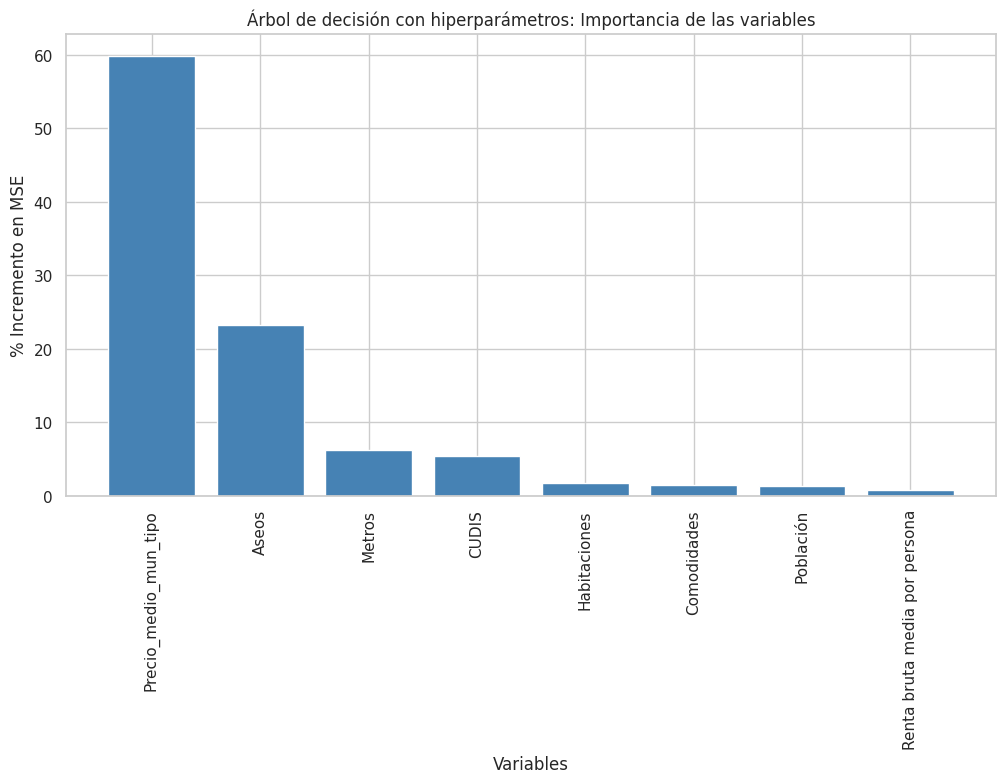

In [28]:
tree_importance = evaluate_feature_importance(model_tree, X_train.columns, title=f"{Modelo}: Importancia de las variables")

### Gráficas

In [29]:
plt.figure(figsize=(300, 60))
plot_tree(
    model_tree,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=None,  # Si es clasificación, puedes incluir nombres de clases
    filled=True,  # Colorear las hojas/nodos según importancia
    rounded=True,  # Bordes redondeados para mejorar la visualización
    fontsize=10  # Tamaño de la fuente
)
plt.title(Modelo)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

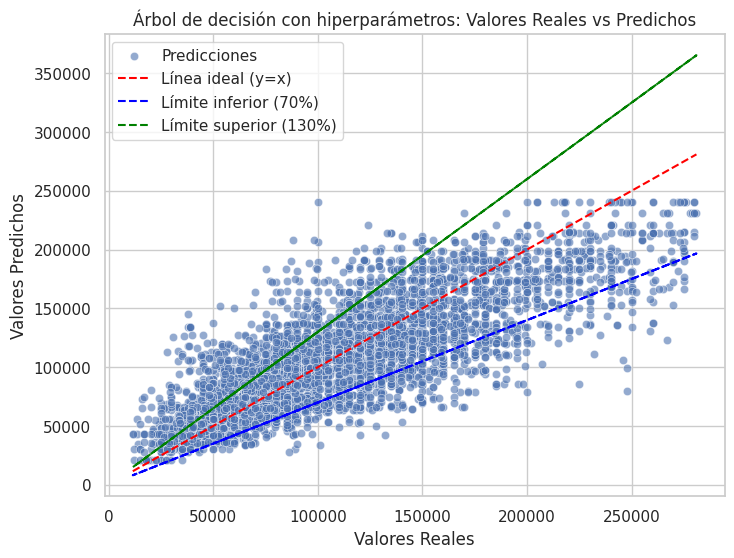

In [30]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Random Forest

### Modelo sin hiperparámetros

In [31]:
rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

Modelo = 'Random Forest sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, model_tree, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Random Forest sin hiperparámetros',
 'RMSE': 32595.961830419208,
 'MAE': 24428.732127792016,
 'R²': 0.6480973005780875,
 'Desviación promedio (%)': 25.66070160494,
 'Tiempo entrenamiento (s)': 0.02893805503845215,
 'RMSE CV': 11.826060512250686,
 'RMSE CV std': 0.007522722805296124,
 'R² CV': 0.6440347514453274,
 'R² CV std': 0.0159441888063722}

### Hiperparámetros

Random Forest es un modelo basado en múltiples árboles de decisión y tiene varios hiperparámetros importantes:

- n_estimators: Número de árboles en el bosque. Valores más altos generalmente mejoran el desempeño, pero también aumentan el tiempo de entrenamiento.
- max_depth: Máxima profundidad de los árboles. Limitar la profundidad ayuda a evitar el sobreajuste.
- min_samples_split: Número mínimo de muestras necesarias para dividir un nodo.
- min_samples_leaf: Número mínimo de muestras necesarias en una hoja.
- max_features: Número máximo de características que el modelo puede usar en cada división. Valores comunes: "auto", "sqrt", "log2".
- bootstrap: Si los datos son muestreados con reemplazo. Generalmente, True funciona bien.

In [32]:
random_forest = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 500, 1000],
    #'max_depth': [5, 10, 15, None],
    'max_features': [1, 5, 10]
    #'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3) #n_jobs=-1,
grid_search_rf.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search_rf.best_params_)
print("Mejor puntuación:", grid_search_rf.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .max_features=1, n_estimators=100;, score=-0.565 total time=   1.3s
[CV 2/5] END .max_features=1, n_estimators=100;, score=-0.583 total time=   1.3s
[CV 3/5] END .max_features=1, n_estimators=100;, score=-0.551 total time=   1.3s
[CV 4/5] END .max_features=1, n_estimators=100;, score=-0.589 total time=   1.2s
[CV 5/5] END .max_features=1, n_estimators=100;, score=-0.562 total time=   1.3s
[CV 1/5] END .max_features=1, n_estimators=500;, score=-0.563 total time=   7.8s
[CV 2/5] END .max_features=1, n_estimators=500;, score=-0.580 total time=   6.3s
[CV 3/5] END .max_features=1, n_estimators=500;, score=-0.549 total time=   7.7s
[CV 4/5] END .max_features=1, n_estimators=500;, score=-0.586 total time=   6.2s
[CV 5/5] END .max_features=1, n_estimators=500;, score=-0.562 total time=   7.6s
[CV 1/5] END max_features=1, n_estimators=1000;, score=-0.563 total time=  14.6s
[CV 2/5] END max_features=1, n_estimators=1000;, 

### Entrenamiento

In [33]:
best_params_rf = grid_search_rf.best_params_
rf_model = RandomForestRegressor(**best_params_rf)
#rf_model = RandomForestRegressor(n_estimators=1000, max_features=10)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

Modelo = 'Random Forest con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, model_tree, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Random Forest con hiperparámetros',
 'RMSE': 32582.089683751838,
 'MAE': 24417.064206184852,
 'R²': 0.6483967614206418,
 'Desviación promedio (%)': 25.651367267654273,
 'Tiempo entrenamiento (s)': 0.028697729110717773,
 'RMSE CV': 11.826072413554282,
 'RMSE CV std': 0.007516393090168329,
 'R² CV': 0.6440347514453274,
 'R² CV std': 0.0159441888063722}

### Gráficas

Importancia de las variables:
                         Feature  %IncMSE      IncNodePurity
7          Precio_medio_mun_tipo    36.11 998,187,790,997.46
2                         Metros    17.08 831,567,630,271.28
1                          Aseos    16.17 567,590,156,347.59
5  Renta bruta media por persona    10.51 688,423,285,945.19
3                          CUDIS     8.54 859,651,455,616.54
4                      Población     4.94 418,913,894,634.90
0                   Habitaciones     4.07 947,045,616,479.24
6                    Comodidades     2.57 941,430,019,298.46


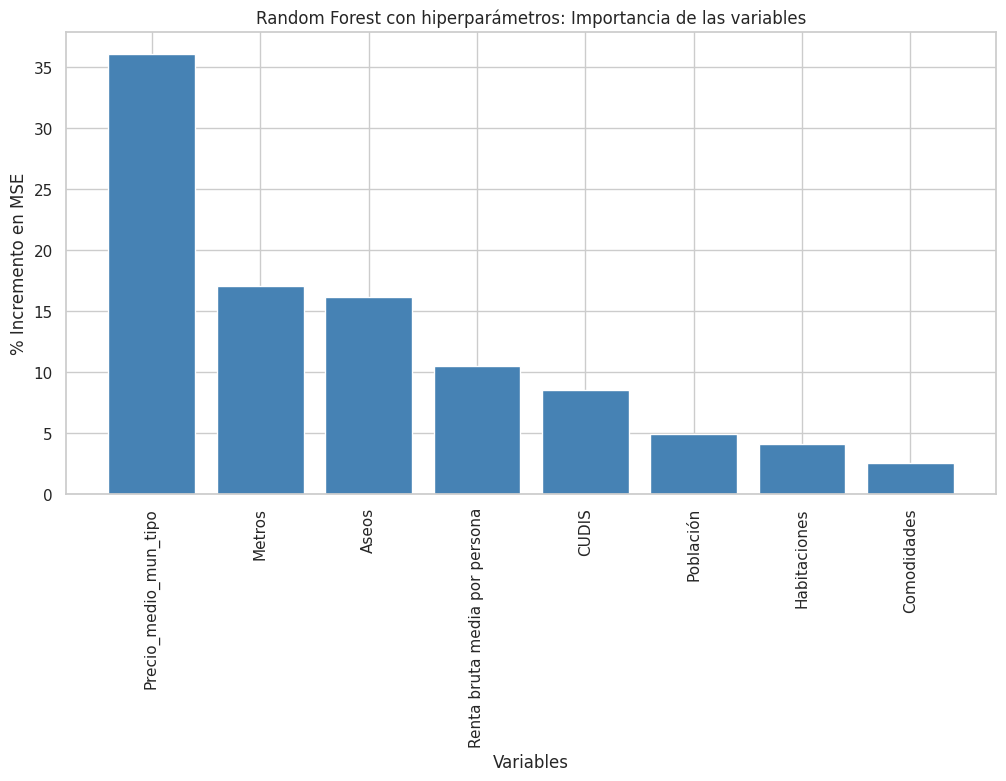

In [34]:
rf_importance = evaluate_feature_importance(rf_model, X_train.columns, title=f"{Modelo}: Importancia de las variables")

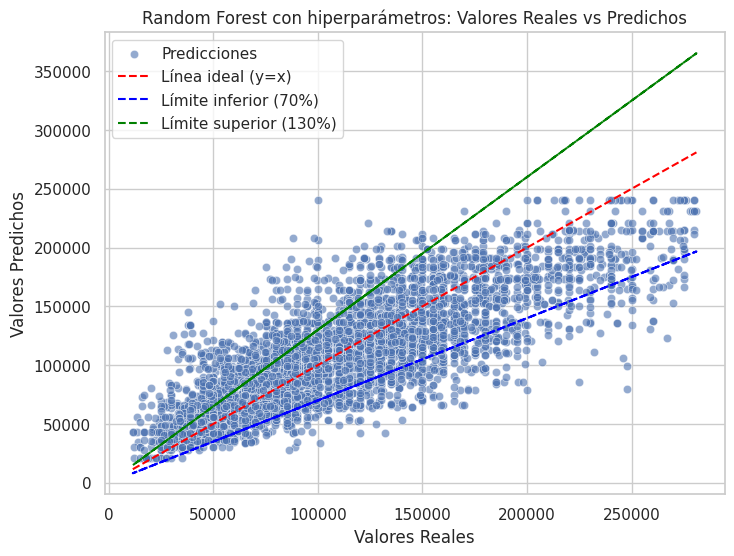

In [35]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## KNN

### Modelo sin hiperparámetros

In [36]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

Modelo = 'KNN sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, knn_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'KNN sin hiperparámetros',
 'RMSE': 35215.18874197858,
 'MAE': 25844.937004844414,
 'R²': 0.5892713119455681,
 'Desviación promedio (%)': 26.71609852929246,
 'Tiempo entrenamiento (s)': 0.021307945251464844,
 'RMSE CV': 11.837045675549001,
 'RMSE CV std': 0.00664456205433489,
 'R² CV': 0.6193140263576102,
 'R² CV std': 0.01503518443505981}

### Hiperparámetros

In [37]:
# Definir los hiperparámetros a probar
param_grid = {
    'n_neighbors': [5, 20, 50],  # Probar diferentes números de vecinos
    'weights': ['uniform', 'distance']  # Evaluar los dos esquemas de ponderación
}

# Configurar el modelo KNN y la búsqueda de hiperparámetros
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3)

# Realizar la búsqueda
grid_search.fit(X_train, y_train)

# Extraer el mejor modelo y sus parámetros
best_knn = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ...n_neighbors=5, weights=uniform;, score=-0.605 total time=   0.1s
[CV 2/5] END ...n_neighbors=5, weights=uniform;, score=-0.627 total time=   0.1s
[CV 3/5] END ...n_neighbors=5, weights=uniform;, score=-0.600 total time=   0.1s
[CV 4/5] END ...n_neighbors=5, weights=uniform;, score=-0.632 total time=   0.1s
[CV 5/5] END ...n_neighbors=5, weights=uniform;, score=-0.617 total time=   0.1s
[CV 1/5] END ..n_neighbors=5, weights=distance;, score=-0.623 total time=   0.1s
[CV 2/5] END ..n_neighbors=5, weights=distance;, score=-0.641 total time=   0.1s
[CV 3/5] END ..n_neighbors=5, weights=distance;, score=-0.620 total time=   0.1s
[CV 4/5] END ..n_neighbors=5, weights=distance;, score=-0.648 total time=   0.1s
[CV 5/5] END ..n_neighbors=5, weights=distance;, score=-0.630 total time=   0.1s
[CV 1/5] END ..n_neighbors=20, weights=uniform;, score=-0.594 total time=   0.1s
[CV 2/5] END ..n_neighbors=20, weights=uniform;, 

In [38]:
best_params_knn = grid_search.best_params_
best_knn_model = grid_search.best_estimator_
#best_knn_model = GradientBoostingRegressor(n_estimators=100, max_depth=7)

Modelo = 'KNN con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, best_knn_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'KNN con hiperparámetros',
 'RMSE': 34304.686733462695,
 'MAE': 25771.12138830897,
 'R²': 0.6102358303769528,
 'Desviación promedio (%)': 27.01930398204989,
 'Tiempo entrenamiento (s)': 0.01600360870361328,
 'RMSE CV': 11.830329859473505,
 'RMSE CV std': 0.005790956680559437,
 'R² CV': 0.6345853877508796,
 'R² CV std': 0.01309452091741298}

### Graficas

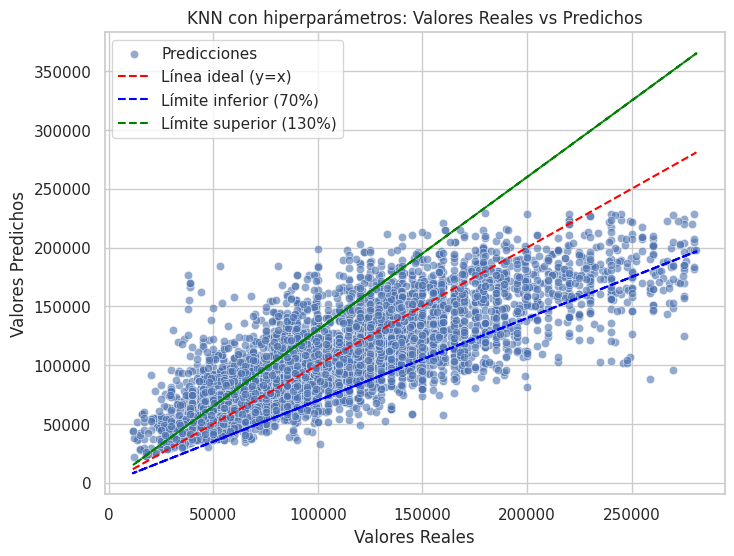

In [39]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Gradient Boosting

### Modelo sin hiperparámetros

In [40]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

Modelo = 'Gradient Boosting sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, gb_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Gradient Boosting sin hiperparámetros',
 'RMSE': 32502.027089563042,
 'MAE': 24502.20858375919,
 'R²': 0.6501225980042735,
 'Desviación promedio (%)': 25.425954133009114,
 'Tiempo entrenamiento (s)': 1.1363246440887451,
 'RMSE CV': 11.814316072975695,
 'RMSE CV std': 0.009035944188617112,
 'R² CV': 0.6695179605986662,
 'R² CV std': 0.018834472692964864}

### Hiperparámetros

In [41]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7]
}

gm_model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gm_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3) #n_jobs=-1,

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=3, n_estimators=100;, score=-0.565 total time=   1.0s
[CV 2/5] END ....max_depth=3, n_estimators=100;, score=-0.582 total time=   1.0s
[CV 3/5] END ....max_depth=3, n_estimators=100;, score=-0.548 total time=   1.0s
[CV 4/5] END ....max_depth=3, n_estimators=100;, score=-0.598 total time=   1.3s
[CV 5/5] END ....max_depth=3, n_estimators=100;, score=-0.577 total time=   1.4s
[CV 1/5] END ....max_depth=3, n_estimators=500;, score=-0.559 total time=   5.2s
[CV 2/5] END ....max_depth=3, n_estimators=500;, score=-0.567 total time=   4.8s
[CV 3/5] END ....max_depth=3, n_estimators=500;, score=-0.532 total time=   6.1s
[CV 4/5] END ....max_depth=3, n_estimators=500;, score=-0.579 total time=   4.8s
[CV 5/5] END ....max_depth=3, n_estimators=500;, score=-0.570 total time=   4.9s
[CV 1/5] END ...max_depth=3, n_estimators=1000;, score=-0.561 total time=  10.7s
[CV 2/5] END ...max_depth=3, n_estimators=1000;, 

In [42]:
best_params_gb = grid_search.best_params_
best_gb_model = grid_search.best_estimator_
#best_gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=7)

Modelo = 'Gradient Boosting con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, best_gb_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Gradient Boosting con hiperparámetros',
 'RMSE': 30738.951173656933,
 'MAE': 22850.315630073223,
 'R²': 0.6870513464639739,
 'Desviación promedio (%)': 23.58044193393618,
 'Tiempo entrenamiento (s)': 3.2849607467651367,
 'RMSE CV': 11.804188815391118,
 'RMSE CV std': 0.007677349696304808,
 'R² CV': 0.6908389433978976,
 'R² CV std': 0.01620882220097994}

### Gráficas

Importancia de las variables:
                         Feature  %IncMSE      IncNodePurity
7          Precio_medio_mun_tipo    53.42 306,725,267,709.88
1                          Aseos    20.79 799,466,675,660.71
2                         Metros     9.05 405,720,394,925.76
3                          CUDIS     6.98 858,895,902,559.95
0                   Habitaciones     3.13 319,060,054,696.30
4                      Población     2.90 480,707,700,304.60
5  Renta bruta media por persona     1.89 632,578,781,668.74
6                    Comodidades     1.84 946,830,939,975.11


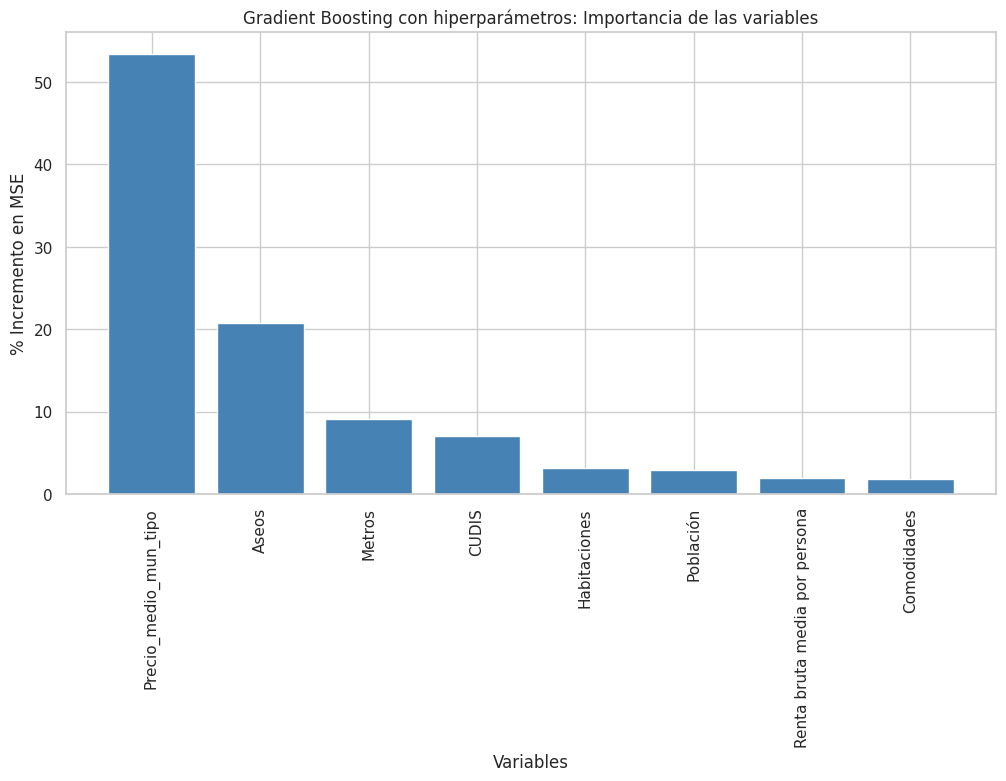

In [43]:
xgm_importance = evaluate_feature_importance(best_gb_model, X_train.columns, title=f"{Modelo}: Importancia de las variables")

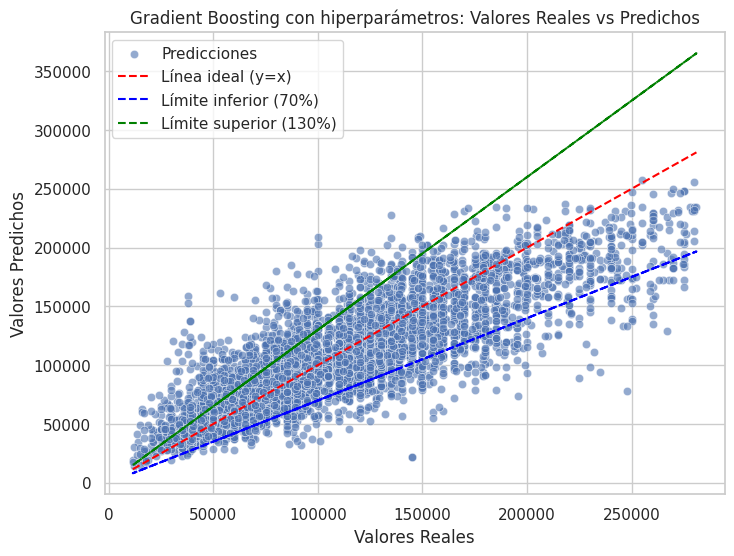

In [44]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## XGBoost

### Modelo sin hiperparámetros

In [45]:
xgb_model = XGBRegressor(random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

Modelo = 'XGBoost sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, xgb_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'XGBoost sin hiperparámetros',
 'RMSE': 30917.698508223693,
 'MAE': 22937.646861140616,
 'R²': 0.6834011646772162,
 'Desviación promedio (%)': 23.675329036894492,
 'Tiempo entrenamiento (s)': 0.1756894588470459,
 'RMSE CV': 11.80934680425283,
 'RMSE CV std': 0.008017256815979808,
 'R² CV': 0.6800062488894452,
 'R² CV std': 0.01839111291696695}

### Hiperparámetros

In [46]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7, 9, None]
}

# Crear el modelo base
xgb_model = XGBRegressor(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3) #, n_jobs=-1)

# Entrenar el modelo con búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ....max_depth=3, n_estimators=100;, score=-0.555 total time=   0.1s
[CV 2/5] END ....max_depth=3, n_estimators=100;, score=-0.574 total time=   0.1s
[CV 3/5] END ....max_depth=3, n_estimators=100;, score=-0.536 total time=   0.1s
[CV 4/5] END ....max_depth=3, n_estimators=100;, score=-0.585 total time=   0.1s
[CV 5/5] END ....max_depth=3, n_estimators=100;, score=-0.568 total time=   0.1s
[CV 1/5] END ....max_depth=3, n_estimators=500;, score=-0.558 total time=   0.4s
[CV 2/5] END ....max_depth=3, n_estimators=500;, score=-0.566 total time=   0.5s
[CV 3/5] END ....max_depth=3, n_estimators=500;, score=-0.544 total time=   0.5s
[CV 4/5] END ....max_depth=3, n_estimators=500;, score=-0.579 total time=   0.5s
[CV 5/5] END ....max_depth=3, n_estimators=500;, score=-0.573 total time=   0.5s
[CV 1/5] END ...max_depth=3, n_estimators=1000;, score=-0.565 total time=   0.9s
[CV 2/5] END ...max_depth=3, n_estimators=1000;,

In [47]:
best_xgb_model = grid_search.best_estimator_
#best_xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

Modelo = 'XGBoost con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, xgb_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'XGBoost con hiperparámetros',
 'RMSE': 30917.698508223693,
 'MAE': 22937.646861140616,
 'R²': 0.6834011646772162,
 'Desviación promedio (%)': 23.675329036894492,
 'Tiempo entrenamiento (s)': 0.17172813415527344,
 'RMSE CV': 11.80934680425283,
 'RMSE CV std': 0.008017256815979808,
 'R² CV': 0.6800062488894452,
 'R² CV std': 0.01839111291696695}

### Graficas

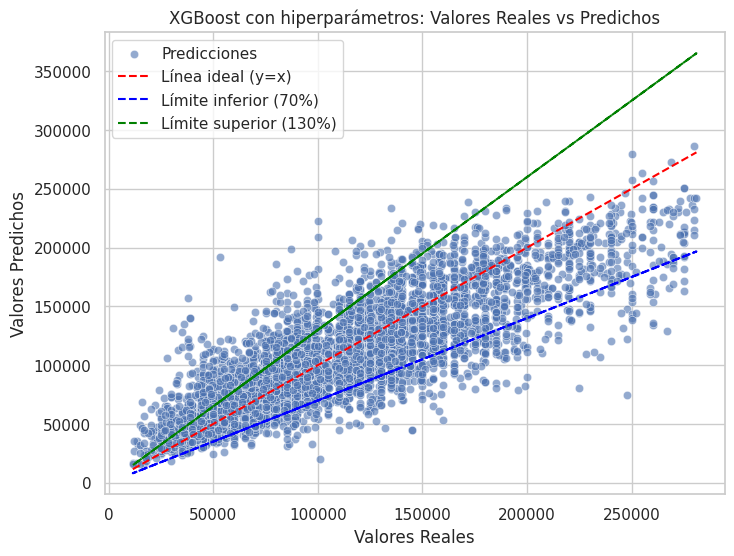

In [48]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## SVR

### Modelo sin hiperparámetros

In [49]:
svr_model = SVR()
svr_model.fit(X_train, y_train)

Modelo = 'Support Vector Machine sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, svr_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Support Vector Machine sin hiperparámetros',
 'RMSE': 33656.64624765036,
 'MAE': 25072.769441099004,
 'R²': 0.6248225966598853,
 'Desviación promedio (%)': 26.565065994288894,
 'Tiempo entrenamiento (s)': 8.107213020324707,
 'RMSE CV': 11.824013798812715,
 'RMSE CV std': 0.009026191122884651,
 'R² CV': 0.6485469309077336,
 'R² CV std': 0.018234420210485942}

### Hiperparámetros

In [50]:
param_grid = {
    'C': [0.1, 1, 5],
    'epsilon': [0.01, 0.5, 1]
    #'kernel': ['rbf', 'poly']
}

grid_search_svr = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=3) #n_jobs=-1,

grid_search_svr.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search_svr.best_params_)
print("Mejor R² obtenido:", grid_search_svr.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..............C=0.1, epsilon=0.01;, score=-0.592 total time=   7.6s
[CV 2/5] END ..............C=0.1, epsilon=0.01;, score=-0.612 total time=   5.8s
[CV 3/5] END ..............C=0.1, epsilon=0.01;, score=-0.581 total time=   7.6s
[CV 4/5] END ..............C=0.1, epsilon=0.01;, score=-0.629 total time=   5.8s
[CV 5/5] END ..............C=0.1, epsilon=0.01;, score=-0.602 total time=   7.1s
[CV 1/5] END ...............C=0.1, epsilon=0.5;, score=-0.594 total time=   2.9s
[CV 2/5] END ...............C=0.1, epsilon=0.5;, score=-0.615 total time=   2.2s
[CV 3/5] END ...............C=0.1, epsilon=0.5;, score=-0.587 total time=   2.2s
[CV 4/5] END ...............C=0.1, epsilon=0.5;, score=-0.630 total time=   2.2s
[CV 5/5] END ...............C=0.1, epsilon=0.5;, score=-0.604 total time=   2.4s
[CV 1/5] END .................C=0.1, epsilon=1;, score=-0.624 total time=   1.1s
[CV 2/5] END .................C=0.1, epsilon=1;, 

In [51]:
best_svr_model = grid_search_svr.best_estimator_
#best_svr_model = SVR(C=1, epsilon=0.01)

Modelo = 'Support Vector Machine con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, best_svr_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Support Vector Machine con hiperparámetros',
 'RMSE': 33905.105491869566,
 'MAE': 25500.177342640374,
 'R²': 0.6192629004928949,
 'Desviación promedio (%)': 26.538804468495847,
 'Tiempo entrenamiento (s)': 2.9162445068359375,
 'RMSE CV': 11.823737975598732,
 'RMSE CV std': 0.008194652484352295,
 'R² CV': 0.6491764005926921,
 'R² CV std': 0.016879803797669207}

### Gráficas

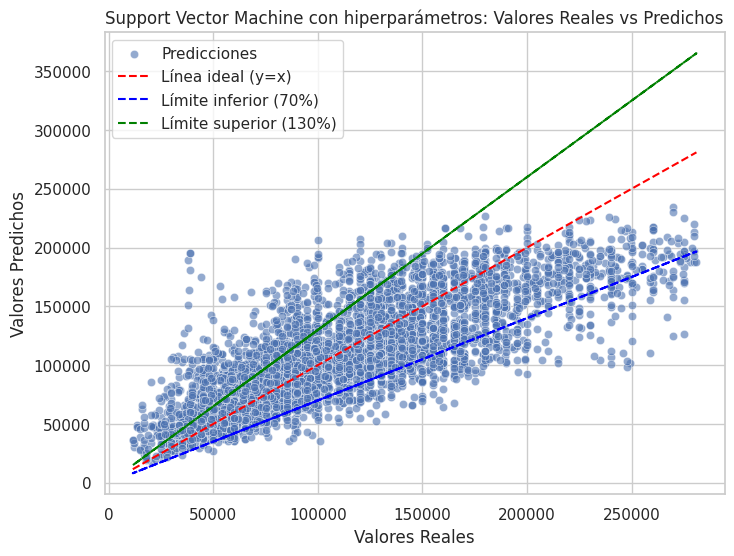

In [52]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Bagging

Crea múltiples modelos independientes (generalmente árboles de decisión) entrenados con diferentes subconjuntos de datos mediante muestreo con reemplazo

### Arbol de Decisión

#### Sin hiperparámetros

In [53]:
# Crear un modelo base (árbol de decisión)
base_model = DecisionTreeRegressor()

# Ensamble con Bagging
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

Modelo = 'Bagging con árbol de decisión'
predictions, model_results = evaluate_model(Modelo, bagging_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Bagging con árbol de decisión',
 'RMSE': 31587.133448384902,
 'MAE': 22447.594639891606,
 'R²': 0.6695426410999021,
 'Desviación promedio (%)': 22.977975275244923,
 'Tiempo entrenamiento (s)': 5.5370025634765625,
 'RMSE CV': 11.813554094138045,
 'RMSE CV std': 0.007704899802591088,
 'R² CV': 0.6711989603466681,
 'R² CV std': 0.016500329138579593}

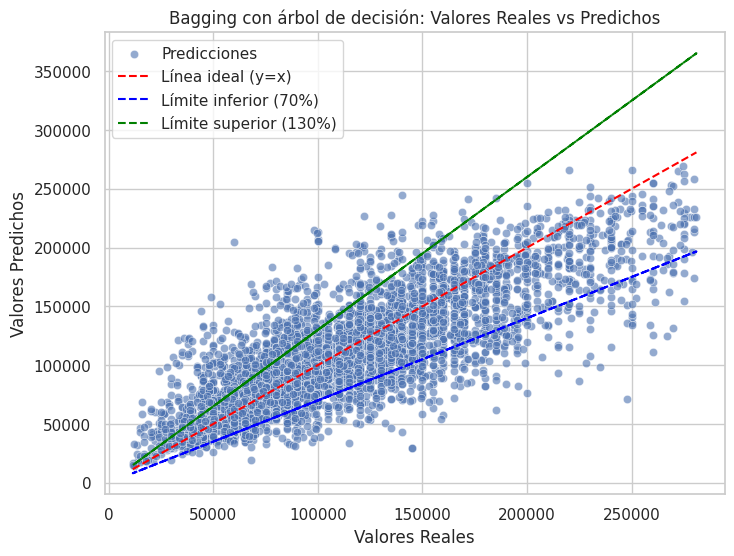

In [54]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

#### Con hiperparámetros

In [55]:
# Crear un modelo base (árbol de decisión)
base_model = DecisionTreeRegressor(**best_params_dt)

# Ensamble con Bagging
bagging_model = BaggingRegressor(base_model, random_state=42)
bagging_model.fit(X_train, y_train)

Modelo = 'Bagging con árbol de decisión con hiperparámetros'
predictions, model_results = evaluate_model(Modelo, bagging_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Bagging con árbol de decisión con hiperparámetros',
 'RMSE': 31923.42457140971,
 'MAE': 23956.520458109055,
 'R²': 0.6624687832357079,
 'Desviación promedio (%)': 24.938957283298148,
 'Tiempo entrenamiento (s)': 0.20615220069885254,
 'RMSE CV': 11.81757015610513,
 'RMSE CV std': 0.008398001626187805,
 'R² CV': 0.6626174676635394,
 'R² CV std': 0.01687910685902476}

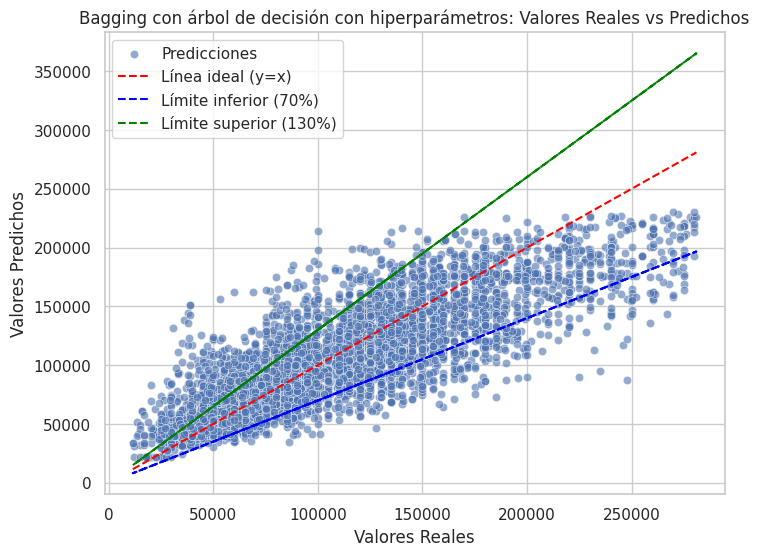

In [56]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

### Random Forest

#### Modelo base

In [57]:
# Crear el modelo Random Forest personalizado
random_forest = RandomForestRegressor(random_state=42)

# Ensamble con Bagging
bagging_model = BaggingRegressor(random_forest, random_state=42)
bagging_model.fit(X_train, y_train)

Modelo = 'Bagging con Random Forest sin hiperparámetros'
predictions, model_results = evaluate_model(Modelo, bagging_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Bagging con Random Forest sin hiperparámetros',
 'RMSE': 30758.642656210253,
 'MAE': 22276.282311950145,
 'R²': 0.6866502659748248,
 'Desviación promedio (%)': 22.91035216786046,
 'Tiempo entrenamiento (s)': 30.835772037506104,
 'RMSE CV': 11.805200364887074,
 'RMSE CV std': 0.0072411393210237394,
 'R² CV': 0.6887898464972615,
 'R² CV std': 0.014972351133564392}

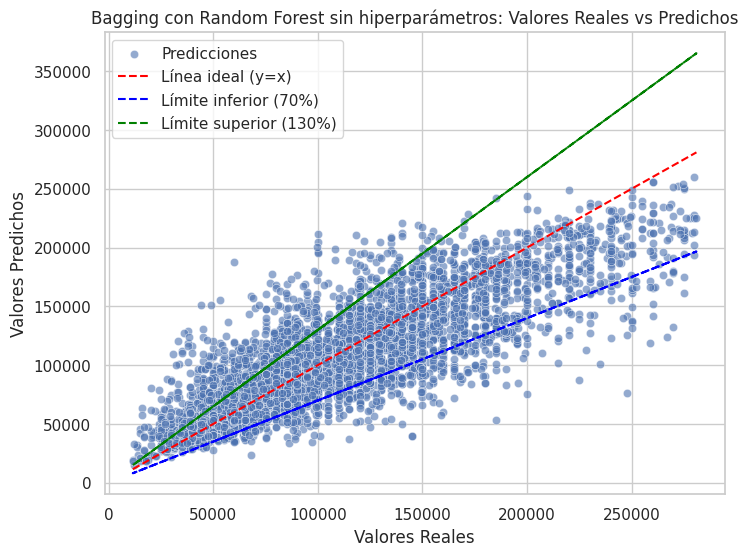

In [58]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Stacking

### Modelos base

In [61]:
# Modelos base
base_models = [
    ('RandomForest', RandomForestRegressor(random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42)),
]

# Modelo meta
meta_model = LinearRegression()

# Ensamble con Stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train, y_train)

Modelo = 'Stacking con Random Forest y Gradient Boosting'
predictions, model_results = evaluate_model(Modelo, stacking_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Stacking con Random Forest y Gradient Boosting',
 'RMSE': 30611.429718507738,
 'MAE': 22615.651542350824,
 'R²': 0.689642514157788,
 'Desviación promedio (%)': 23.256229147665838,
 'Tiempo entrenamiento (s)': 29.869096040725708,
 'RMSE CV': 11.801900902828404,
 'RMSE CV std': 0.008760446261654288,
 'R² CV': 0.6954942087227873,
 'R² CV std': 0.01795524777025674}

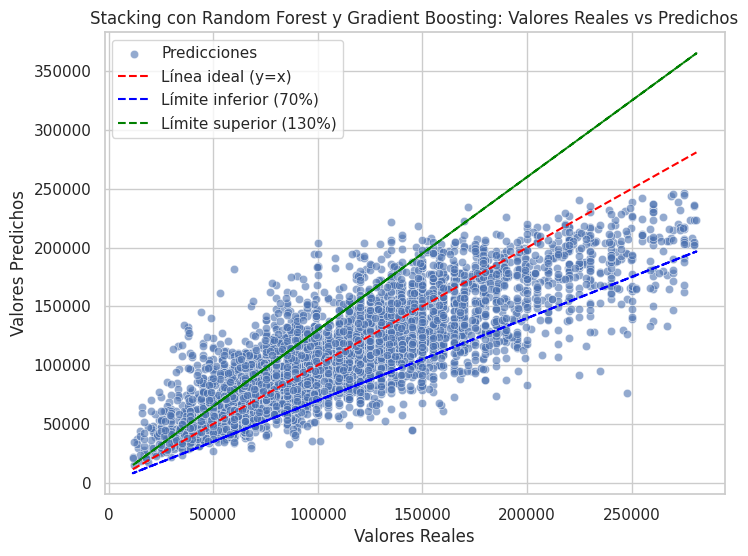

In [62]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

### Modelos base + XGBoost

In [63]:
# Definir los modelos base
estimators = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42))
]

# Modelo final (meta-modelo)
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=XGBRegressor(random_state=42)
)

# Entrenar el modelo
stacking_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_stacking = stacking_model.predict(X_test)

# Evaluar rendimiento

Modelo = 'Stacking con Random Forest, Gradient Boosting y XGBoost'
predictions, model_results = evaluate_model(Modelo, stacking_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)


{'Modelo': 'Stacking con Random Forest, Gradient Boosting y XGBoost',
 'RMSE': 32155.511696095386,
 'MAE': 23715.20928446755,
 'R²': 0.657543158302663,
 'Desviación promedio (%)': 24.40718276784836,
 'Tiempo entrenamiento (s)': 29.886618614196777,
 'RMSE CV': 11.820978394429982,
 'RMSE CV std': 0.008401087521786648,
 'R² CV': 0.6552342229841855,
 'R² CV std': 0.016805608522952206}

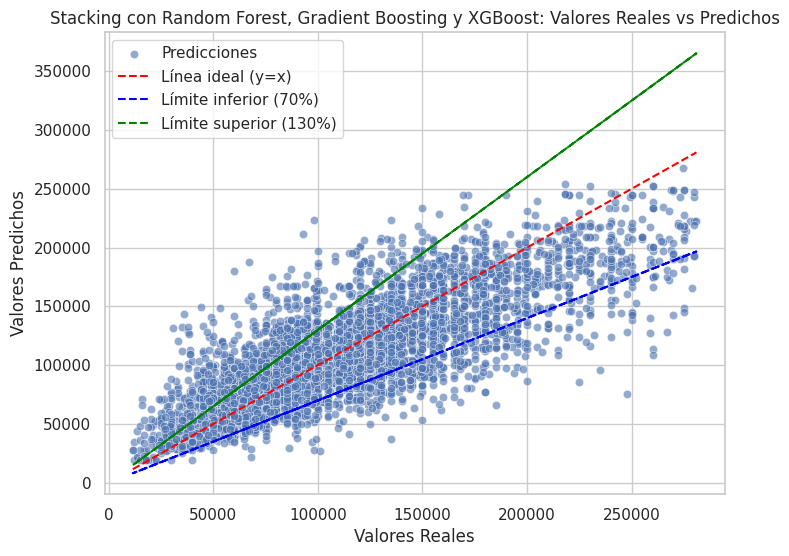

In [64]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

## Voting

### Modelos base

In [65]:
# Crear modelos individuales
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Ensamble con Voting
voting_model = VotingRegressor(estimators=[('RandomForest', random_forest), ('GradientBoosting', gradient_boosting)])
voting_model.fit(X_train, y_train)

# Predicciones
y_pred_voting = voting_model.predict(X_test)

Modelo = 'Voting Random Forest y Gradient Boosting'
predictions, model_results = evaluate_model(Modelo, voting_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Voting Random Forest y Gradient Boosting',
 'RMSE': 30678.971342902234,
 'MAE': 22663.380718331522,
 'R²': 0.6882714462621908,
 'Desviación promedio (%)': 23.272681750803475,
 'Tiempo entrenamiento (s)': 6.656521558761597,
 'RMSE CV': 11.801913920316352,
 'RMSE CV std': 0.008679791601661838,
 'R² CV': 0.6954782805876136,
 'R² CV std': 0.017702939029627555}

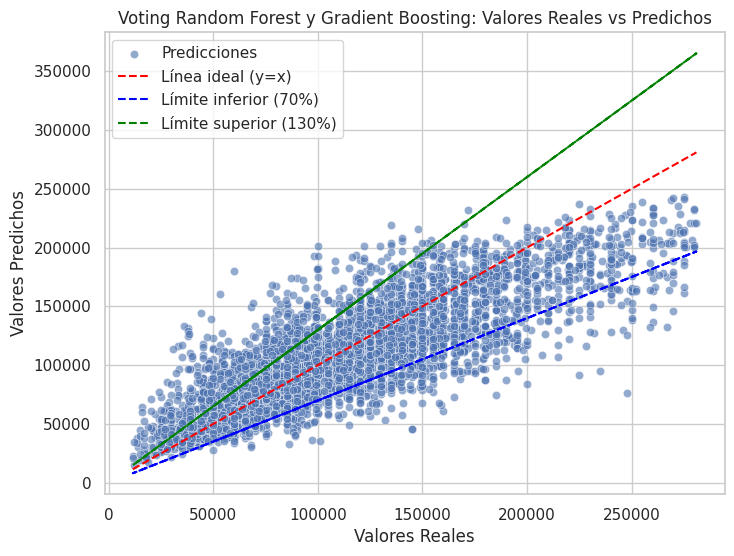

In [66]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

### Modelos Base + XGBoost

In [67]:
# Definir los modelos
voting_model = VotingRegressor([
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42))
])

# Entrenar el modelo
voting_model.fit(X_train, y_train)

Modelo = 'Voting Random Forest, Gradient Boosting y XGBoost'
predictions, model_results = evaluate_model(Modelo, voting_model, X_train, y_train, X_test, y_test, model_results, scaler_y)
get_model_results(Modelo, model_results)

{'Modelo': 'Voting Random Forest, Gradient Boosting y XGBoost',
 'RMSE': 30352.85627694268,
 'MAE': 22428.261366937284,
 'R²': 0.6948635227119212,
 'Desviación promedio (%)': 23.044868502793054,
 'Tiempo entrenamiento (s)': 5.417769432067871,
 'RMSE CV': 11.80002447016099,
 'RMSE CV std': 0.00856117448260647,
 'R² CV': 0.6993226872955458,
 'R² CV std': 0.017774670533491885}

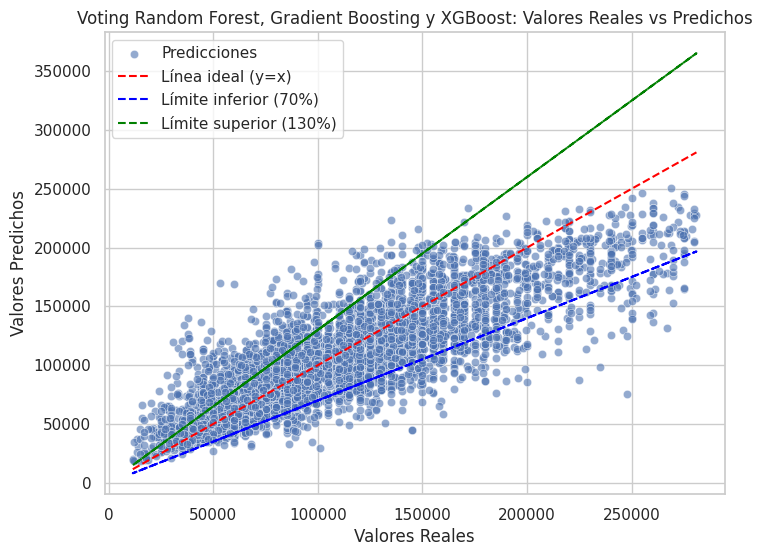

In [68]:
y_test_rescaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).ravel()
plot_predictions(np.exp(y_test_rescaled), predictions, title=f"{Modelo}: Valores Reales vs Predichos")

# Resumen de los modelos

In [69]:
pd.DataFrame(model_results)

,Modelo,RMSE,MAE,R²,Desviación promedio (%),Tiempo entrenamiento (s),RMSE CV,RMSE CV std,R² CV,R² CV std
0,Regresión lineal,"37,401.24","28,104.69",0.54,28.69,0.04,11.84,0.01,0.60,0.02
1,Árbol de decisión sin hiperparámetros,"39,251.69","27,206.26",0.49,28.12,0.19,11.90,0.01,0.47,0.02
2,Árbol de decisión con hiperparámetros,"32,587.08","24,421.06",0.65,25.65,0.07,11.83,0.01,0.64,0.02
3,Random Forest sin hiperparámetros,"32,595.96","24,428.73",0.65,25.66,0.03,11.83,0.01,0.64,0.02
4,Random Forest con hiperparámetros,"32,582.09","24,417.06",0.65,25.65,0.03,11.83,0.01,0.64,0.02
5,KNN sin hiperparámetros,"35,215.19","25,844.94",0.59,26.72,0.02,11.84,0.01,0.62,0.02
6,KNN con hiperparámetros,"34,304.69","25,771.12",0.61,27.02,0.02,11.83,0.01,0.63,0.01
7,Gradient Boosting sin hiperparámetros,"32,502.03","24,502.21",0.65,25.43,1.14,11.81,0.01,0.67,0.02
8,Gradient Boosting con hiperparámetros,"30,738.95","22,850.32",0.69,23.58,3.28,11.80,0.01,0.69,0.02
9,XGBoost sin hiperparámetros,"30,917.70","22,937.65",0.68,23.68,0.18,11.81,0.01,0.68,0.02


Análisis de múltiples modelos de aprendizaje automático con y sin **hiperparámetros**.

---

### **1. Modelos con Mejor Rendimiento**
El **mejor modelo según R²** es **Voting con Random Forest, Gradient Boosting y XGBoost (Modelo 19)** con:
- **R² = 0.70** → Explica **70% de la variabilidad** en los datos.
- **RMSE = 30,352** → Error más bajo entre todas las opciones.
- **MAE = 22,428** → Error absoluto medio más bajo.

**Otros modelos competitivos con R² = 0.69:**  
- **Stacking con Random Forest y Gradient Boosting (Modelo 16)**
- **Gradient Boosting con hiperparámetros (Modelo 8)**
- **Bagging con Random Forest sin hiperparámetros (Modelo 15)**
- **Voting con Random Forest y Gradient Boosting (Modelo 18)**

Estos modelos tienen **buen ajuste y estabilidad**, aunque **Stacking con Random Forest, Gradient Boosting y XGBoost (Modelo 17) es ligeramente menos eficiente en comparación con Voting y Bagging**.

✅ **Conclusión sobre precisión:** **Voting con RF, GB y XGBoost (Modelo 19) es la opción con mejores métricas de error y ajuste.**

---

### **2. Impacto de los Hiperparámetros**
Los modelos con hiperparámetros tienden a mejorar respecto a sus versiones base:
- **Árbol de decisión:** Mejoró **de R² = 0.49 a 0.65**.
- **Gradient Boosting:** Mejoró **de R² = 0.65 a 0.69**.
- **XGBoost:** Subió **de R² = 0.68 a 0.69**, pero la diferencia es mínima.

🔹 **Mayor impacto:** **Gradient Boosting con hiperparámetros es el que más se benefició del ajuste**.  
🔹 **Menor impacto:** **XGBoost con hiperparámetros tiene mejoras marginales respecto al modelo sin ajuste**.  

✅ **Conclusión sobre hiperparámetros:** **Vale la pena ajustarlos en Gradient Boosting y Árboles de Decisión, pero XGBoost ya tiene alto rendimiento en su versión base.**

---

### **3. Modelos más Estables (Desviación Promedio y RMSE CV)**
Para asegurar un modelo **robusto y que generalice bien**, observamos:
- **Menor desviación promedio:** **Bagging con Random Forest (Modelo 15, 22.91%)**, seguido de **Voting con XGBoost (Modelo 19, 23.04%)**.
- **Menor variabilidad en RMSE CV std:** **Todos los modelos tienen RMSE CV std ≈ 1.01**, indicando consistencia.

✅ **Conclusión sobre estabilidad:** **Bagging con RF y Voting con XGBoost son los modelos más confiables en diferentes conjuntos de datos.**

---

### **4. Tiempo de Entrenamiento**
Si buscas **eficiencia computacional**:
- **Más rápido:** **Regresión Lineal (0.04s), Random Forest con hiperparámetros (0.03s), XGBoost con hiperparámetros (0.17s).**
- **Más lento:** **Stacking con RF, GB y XGBoost (Modelo 17, 29.89s), Bagging con Random Forest (Modelo 15, 30.84s).**

✅ **Conclusión sobre tiempo:** Si buscas velocidad, XGBoost sin hiperparámetros (0.18s) es una gran opción con **buen equilibrio entre rapidez y precisión**.

---

### **5. Elección del Mejor Modelo**
Dependiendo de tu prioridad:

🔹 **Si buscas máxima precisión:** **Voting con XGBoost (Modelo 19)** es la opción más fuerte.  
🔹 **Si prefieres estabilidad:** **Bagging con Random Forest (Modelo 15)** es el más seguro.  
🔹 **Si necesitas eficiencia en tiempo:** **XGBoost con hiperparámetros (Modelo 10)** ofrece rapidez y precisión.  
🔹 **Si quieres equilibrio entre precisión y estabilidad:** **Stacking con RF y GB (Modelo 16)** es muy fuerte.  

---

#Exportación del modelo elegido

In [73]:
# Exportar el StandardScaler de la matriz de entrada (X)
joblib.dump(scaler_X, '/content/drive/My Drive/tfm/codigo/modelo_ml/standardscaler_datos_entrada.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ml/standardscaler_datos_entrada.pkl']

In [75]:
# Exportar el StandardScaler de la variable precio (y)
joblib.dump(scaler_y, '/content/drive/My Drive/tfm/codigo/modelo_ml/standardscaler_precio.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ml/standardscaler_precio.pkl']

In [76]:
# Modelo de xgb
joblib.dump(best_xgb_model, '/content/drive/My Drive/tfm/codigo/modelo_ml/modelo_xgb.pkl')

['/content/drive/My Drive/tfm/codigo/modelo_ml/modelo_xgb.pkl']